# ***I have to mention that all the necessary explanations about the codes are provided in the report***

# Import

In [24]:
import torch
import torch.nn as nn
import cv2
import os

import torchvision.models as models
import torchvision.transforms.functional as TF
import torchvision.utils as utils
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd

from torch.optim.lr_scheduler import StepLR

import random
import matplotlib.patches as patches

import torchvision
from torchvision import ops

import xml.etree.ElementTree as ET
import torch.optim as optim

# Config and Init

In [25]:
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Utils

In [26]:
def pre_EDA(path, files):
    i = 0
    results = dict({}) # The dictionary that we are going to store the results in
    for f_path in files:

        results[i] = dict({})
        with open(os.path.join(path, f_path), 'r') as f:
            lines = f.readlines()
        j = 0
        for line in lines: # Read each line
            data = line.strip().split()
            class_label = int(data[0]) + 1
            x_center = float(data[1])
            y_center = float(data[2])
            width = float(data[3])
            height = float(data[4])
            results[i][j] = {'width':width, 'height':height,
                             'center_x':x_center, 'center_y':y_center,
                             'label':class_label}
            j += 1
        i += 1

    return results

# Visualization utils

In [27]:
def display_img(img, fig, axes):
    # Convert image to torch tensor and permute dimensions
    img = img.clone().detach().permute(1, 0, 2)  # Convert HWC to CHW
    img = img.clone().detach().permute(0, 2, 1).numpy() # Reconvert
    axes.imshow(img)
    axes.axis('off')

    return fig, axes

In [28]:
def display_bbox(bboxes, fig, ax, classes=None, in_format='xyxy', color='y', line_width=3):
    if type(bboxes) == np.ndarray:
        bboxes = torch.from_numpy(bboxes)

    # Convert boxes to xywh format
    bboxes = ops.box_convert(bboxes, in_fmt=in_format, out_fmt='xywh')
    c = 0
    for box in bboxes:
        x, y, w, h = box.numpy()
        if w !=0 and h!=0:
            # Display bounding box
            rect = patches.Rectangle((x, y), w, h, linewidth=line_width, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            # Display category
            name2idx = {'pad': -1, 'fish': 0, 'jellyfish': 1, 'penguin': 2, 'puffin': 3, 'shark': 4, 'starfish': 5, 'stingray': 6}
            idx2name = {v: k for k, v in name2idx.items()}

            if classes is not None:
                if idx2name[classes[c].item()] == 'pad':
                    continue
                ax.text(x + 5, y + 20, idx2name[classes[c].item()], bbox=dict(facecolor='yellow', alpha=0.5), fontsize=8)

            c += 1

    return fig, ax

In [29]:
def display_images(loader, num_images=10):
    n_rows = num_images // 5
    n_cols = num_images // (num_images // 5)
    figsize = (n_cols*4, n_rows*4)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    image_count = 0

    for img_batch, target_batch in loader:
        gt_bboxes_all = [t['boxes'] for t in target_batch]
        gt_classes_all = [t['labels'] for t in target_batch]

        for i in range(len(img_batch)):
            if image_count >= num_images:
                break

            img = img_batch[i]
            bboxes = gt_bboxes_all[i]
            classes = gt_classes_all[i]

            fig, axes[image_count] = display_img(img, fig, axes[image_count])
            fig, axes[image_count] = display_bbox(bboxes, fig, axes[image_count], classes=classes)

            image_count += 1

        if image_count >= num_images:
            break

    plt.show()

In [30]:
def object_dist(train, test, valid):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

    data = [train, test, valid]
    name = ['train', 'test', 'valid']

    for i in range(3):
        axes[i].hist([len(data[i][dic]) for dic in data[i]], bins=100, density=True)
        axes[i].set_xlabel('Number of objects')
        axes[i].set_ylabel(f"Density in {name[i]} DataSet")
        axes[i].set_title(f"Distribution of number of objects in images ({name[i]})", fontsize=10)

    plt.show()

In [31]:
def num_class_dist(train, test, valid):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

    data = [train, test, valid]
    name = ['train', 'test', 'valid']

    for i in range(3):
        axes[i].hist([len(set(data[i][dic][j]['label'] for j in range(len(data[i][dic])))) for dic in data[i]], bins=100)
        axes[i].set_xlabel('Number of different classes')
        axes[i].set_ylabel(f"Density in {name[i]} DataSet")
        axes[i].set_title(f"Distribution of different objects in images ({name[i]})", fontsize=10)

    plt.show()

In [32]:
def classes_dist1(train, test, valid):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

    data = [train, test, valid]
    name = ['train', 'test', 'valid']

    for i in range(3):

        dist = [0 for j in range(7)]
        for dic in data[i]:
            for j in range(len(data[i][dic])):
                dist[data[i][dic][j]['label']-1] += 1

        axes[i].bar([j for j in range(1, 8)], dist)
        axes[i].set_xlabel('Different classes')
        axes[i].set_ylabel(f"Density in {name[i]} DataSet")
        axes[i].set_title(f"Distribution of classes in all the images ({name[i]})", fontsize=10)

    plt.show()

In [33]:
def classes_dist2(train, test, valid):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

    data = [train, test, valid]
    name = ['train', 'test', 'valid']

    for i in range(3):

        dist = [0 for j in range(7)]
        for dic in data[i]:
            dist_set = set(data[i][dic][j]['label'] for j in range(len(data[i][dic])))
            for c in dist_set:
                dist[c-1] += 1

        axes[i].bar([j for j in range(1, 8)], dist)
        axes[i].set_xlabel('Different classes')
        axes[i].set_ylabel(f"Density in {name[i]} DataSet")
        axes[i].set_title(f"Distribution of images containing a class ({name[i]})", fontsize=10)

    plt.show()

# EDA

In [34]:
train_labels_path = "./drive/MyDrive/NNDL/Project3-NNDL/Q2/aquarium_pretrain/train/labels"
test_labels_path = "./drive/MyDrive/NNDL/Project3-NNDL/Q2/aquarium_pretrain/test/labels"
valid_labels_path = "./drive/MyDrive/NNDL/Project3-NNDL/Q2/aquarium_pretrain/valid/labels"

train_bb = [file for file in os.listdir(train_labels_path) if file.endswith(('.txt'))]
test_bb = [file for file in os.listdir(test_labels_path) if file.endswith(('.txt'))]
valid_bb = [file for file in os.listdir(valid_labels_path) if file.endswith(('.txt'))]

train_res = pre_EDA(train_labels_path, train_bb)
test_res = pre_EDA(test_labels_path, test_bb)
valid_res = pre_EDA(valid_labels_path, valid_bb)

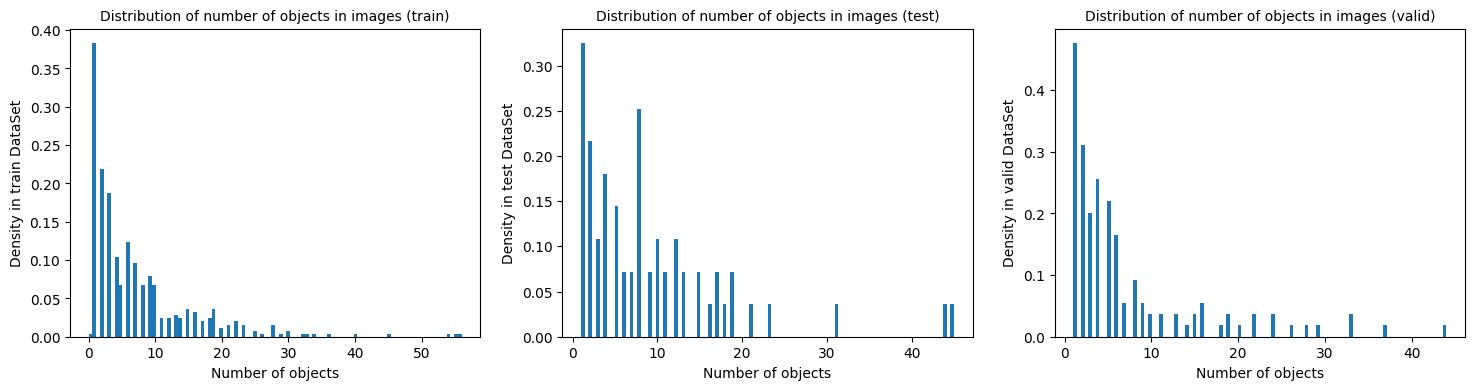

In [35]:
object_dist(train_res, test_res, valid_res)

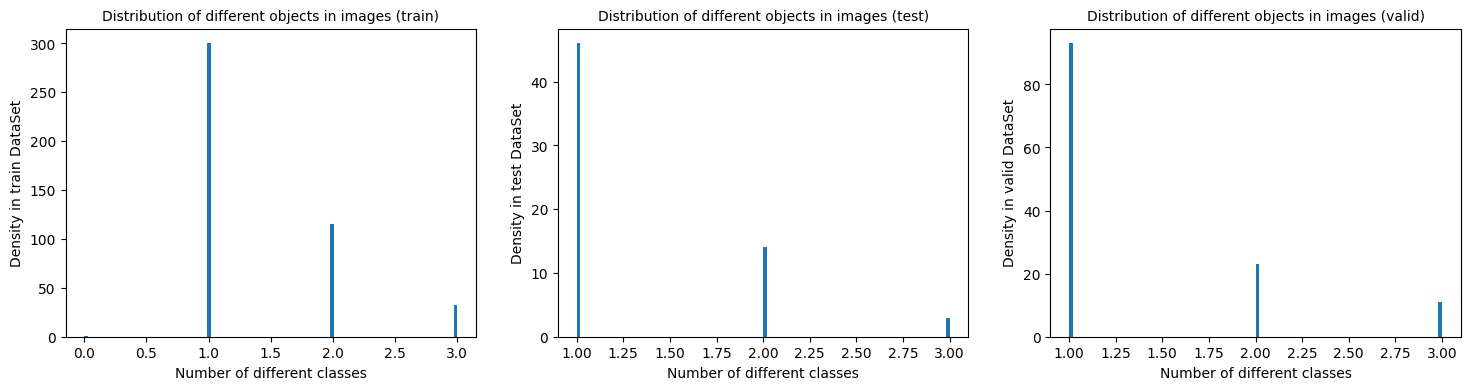

In [36]:
num_class_dist(train_res, test_res, valid_res)

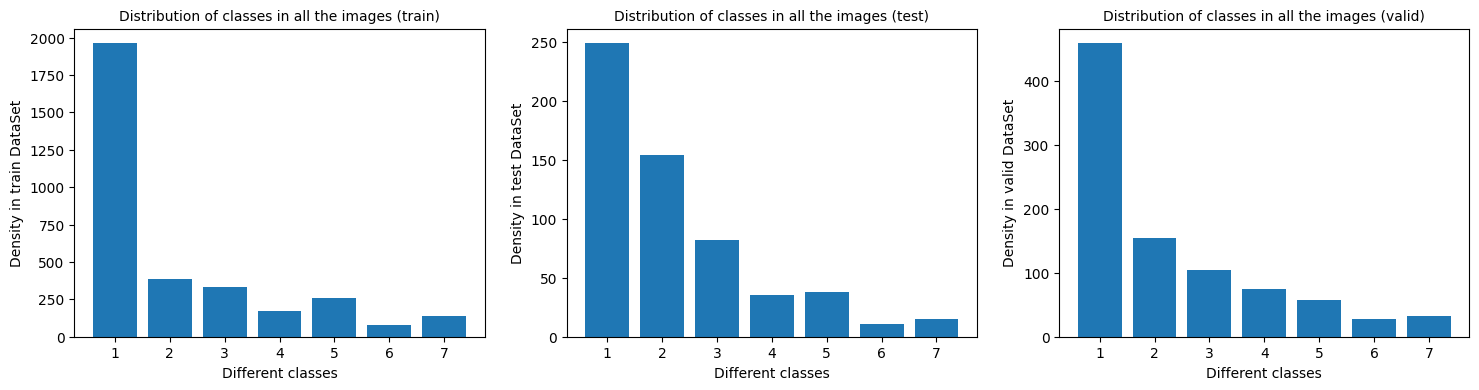

In [37]:
classes_dist1(train_res, test_res, valid_res)

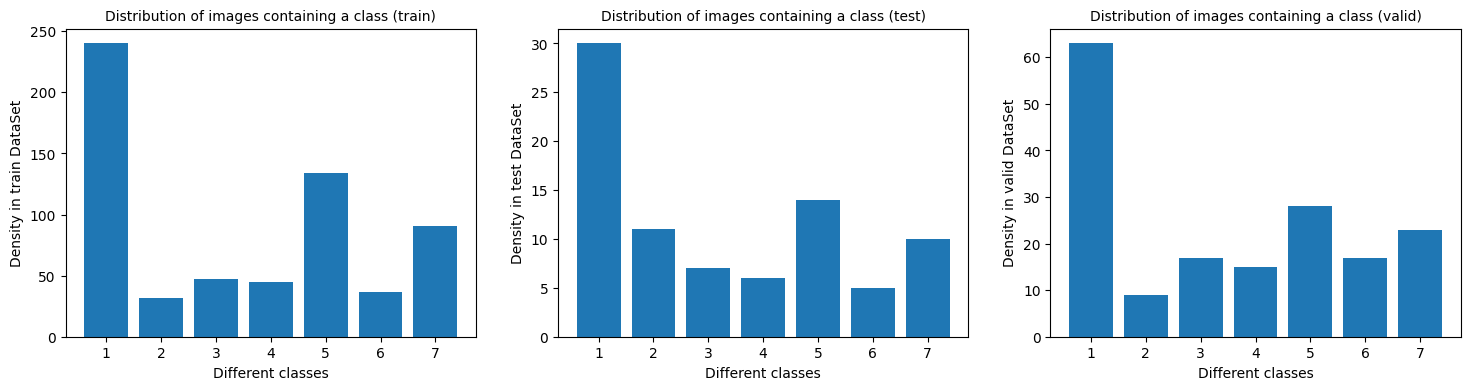

In [38]:
classes_dist2(train_res, test_res, valid_res)

# Dataset and Dataloader

In [39]:
def collate_fn(batch):
    images = []
    targets = []
    max_num_boxes = max(len(target['boxes']) for _, target in batch)

    for image, target in batch:
        num_boxes = len(target['boxes'])

        # Pad boxes and labels to match max_num_boxes
        padded_boxes = torch.zeros((max_num_boxes, 4), dtype=torch.float32)
        padded_labels = torch.zeros((max_num_boxes,), dtype=torch.int64)

        if num_boxes > 0:
            padded_boxes[:num_boxes] = target["boxes"][:max_num_boxes]
            padded_labels[:num_boxes] = target["labels"][:max_num_boxes]

        images.append(image)
        targets.append({
            'boxes': padded_boxes,
            'labels': padded_labels
        })

    return torch.stack(images), targets

In [40]:
class Aquarium(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = sorted(os.listdir(os.path.join(root_dir, 'images')))
        self.label_files = sorted(os.listdir(os.path.join(root_dir, 'labels')))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        label_name = self.label_files[idx]

        image_path = os.path.join(self.root_dir, 'images', img_name)
        label_path = os.path.join(self.root_dir, 'labels', label_name)

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height, width, _ = image.shape

        # Read bounding box and labels
        with open(label_path, 'r') as f:
            lines = f.readlines()

        boxes = []
        labels = []
        for line in lines:
            # Get bounding box coordinates and class label
            data = line.strip().split()
            class_label = int(data[0])
            x_center = float(data[1]) * width
            y_center = float(data[2]) * height
            box_width = float(data[3]) * width
            box_height = float(data[4]) * height

            xmin = x_center - (box_width / 2)
            ymin = y_center - (box_height / 2)
            xmax = x_center + (box_width / 2)
            ymax = y_center + (box_height / 2)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(class_label)

        if self.transform:
            transformed = self.transform(image=image, bboxes=boxes, labels=labels)
            image = transformed['image']
            boxes = transformed['bboxes']

        return image, {
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64)
        }

In [41]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

additional_transform = A.Compose([
    A.GaussNoise(var_limit=(10, 100), mean=0, per_channel=True, p=0.5),
    A.ColorJitter(brightness=(0.8, 1), contrast=(0.8, 1), saturation=(0.8, 1), hue=(-0.2, 0.2), p=0.5),
    # A.Rotate((-180, 180), p=0.9),
    # A.RandomCrop(width=280, height=280, p=1),
    A.RGBShift(r_shift_limit=(-20, 20), g_shift_limit=(-20, 20), b_shift_limit=(-20, 20), p=0.5),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

transform = A.Compose([
    additional_transform,
    A.Resize(width=256, height=256, p=1),
    ToTensorV2(p=1.0),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

transform_test = A.Compose([
    A.Resize(width=256, height=256, p=1),
    ToTensorV2(p=1.0),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [42]:
# Create an instance of the Aquarium class with the defined transformation
train_set = Aquarium(root_dir="./drive/MyDrive/NNDL/Project3-NNDL/Q2/aquarium_pretrain/train", transform=transform)
test_set = Aquarium(root_dir="./drive/MyDrive/NNDL/Project3-NNDL/Q2/aquarium_pretrain/test", transform=transform_test)
valid_set = Aquarium(root_dir="./drive/MyDrive/NNDL/Project3-NNDL/Q2/aquarium_pretrain/valid", transform=transform_test)

batch_size = 16

# Create a DataLoader with the collate function
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

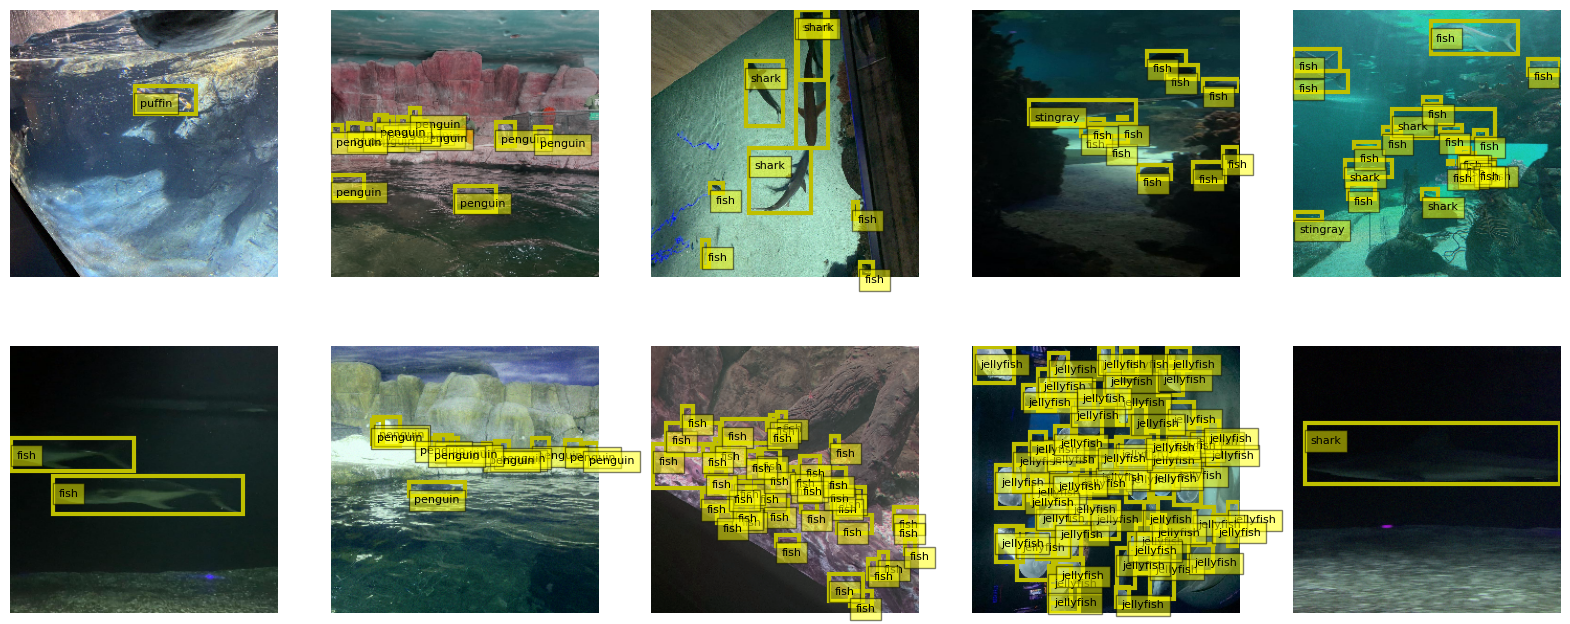

In [43]:
display_images(train_loader, num_images=10)

# Model

## Backbone model

In [44]:
def get_backbone_model(pretrained=True):
    # Load the pretrained ResNet-101 model
    resnet101 = models.resnet101(pretrained=pretrained)
    # Remove the fully connected layer
    modules = list(resnet101.children())[:-2]
    backbone = nn.Sequential(*modules)
    return backbone

backbone = get_backbone_model()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:02<00:00, 70.2MB/s]


In [45]:
for img_batch, target_batch in train_loader:
        gt_bboxes_all = [t['boxes'] for t in target_batch]
        gt_classes_all = [t['labels'] for t in target_batch]
        img_data_all = img_batch
        break

img_data_all = img_data_all.float() / 255.0

with torch.no_grad():
    out = backbone(img_data_all)

out_c, out_h, out_w = out.size(1), out.size(2), out.size(3)

img_height, img_width = img_data_all.size(2), img_data_all.size(3)
width_scale_factor = img_width // out_w
height_scale_factor = img_height // out_h

print("Width Scale Factor:", width_scale_factor)
print("Height Scale Factor:", height_scale_factor)

Width Scale Factor: 32
Height Scale Factor: 32


In [46]:
def plot_feature_maps(feature_maps, num_maps=8):
    fig, axes = plt.subplots(num_maps // 5, num_maps // (num_maps // 5), figsize=(12, 4))
    axes = axes.flatten()
    for i in range(num_maps):
        axes[i].imshow(feature_maps[0, i].cpu().numpy(), cmap='viridis')
        axes[i].axis('off')
    plt.show()

### Feature maps

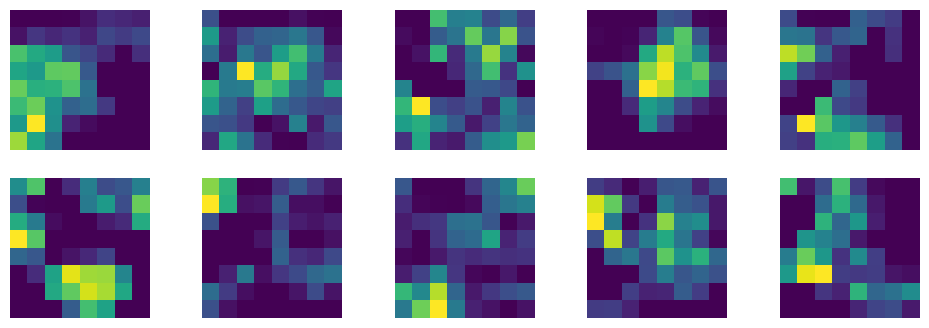

In [47]:
plot_feature_maps(out, num_maps=10)

In [48]:
def generate_anchor_points(out_h, out_w, height_scale_factor, width_scale_factor):
    y = np.arange(out_h) * height_scale_factor + height_scale_factor // 2
    x = np.arange(out_w) * width_scale_factor + width_scale_factor // 2
    xv, yv = np.meshgrid(x, y)
    return xv, yv

In [49]:
def plot_anchor_points(img_data_all, gt_bboxes_all, gt_classes_all, backbone):
    fig, axes = plt.subplots(2, 5, figsize=(16, 8))

    for idx in range(10):
        img_data = img_data_all[idx]
        img_height, img_width = img_data.size(1), img_data.size(2)

        with torch.no_grad():
            out = backbone(img_data.unsqueeze(0))

        out_c, out_h, out_w = out.size(1), out.size(2), out.size(3)
        width_scale_factor = img_width // out_w
        height_scale_factor = img_height // out_h

        # Generate anchor points
        xv, yv = generate_anchor_points(out_h, out_w, height_scale_factor, width_scale_factor)

        ax = axes[idx // 5, idx % 5]
        img = img_data.permute(1, 2, 0).cpu().numpy()
        ax.imshow(img)
        ax.scatter(xv.flatten(), yv.flatten(), s=10, color='white')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

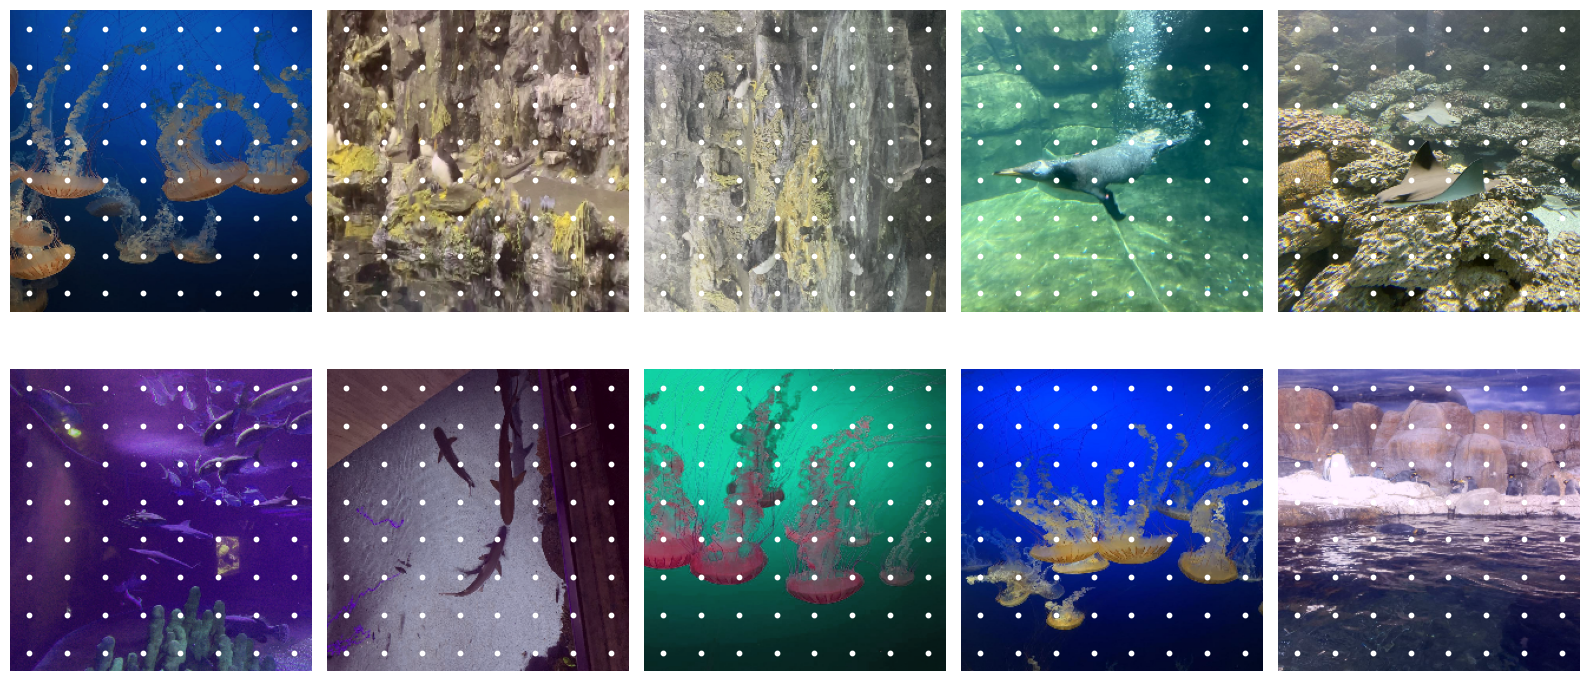

In [50]:
plot_anchor_points(img_data_all, gt_bboxes_all, gt_classes_all, backbone)

## Generate and Plot Anchor Points

In [51]:
from sklearn.cluster import KMeans

In [52]:
def kmeans_plusplus(X, k):
    centers = [X[np.random.choice(len(X))]]  # Select the first cluster center randomly
    while len(centers) < k:
        distances = np.array([min(np.linalg.norm(x - c) for c in centers) for x in X])
        next_center = X[np.argmax(distances)]  # Select the next center based on maximum distance
        centers.append(next_center)
    return np.array(centers)

In [53]:
bbox_sizes = []
for dic in train_res:
    for image_bb in train_res[dic]:
        bbox_sizes.append([train_res[dic][image_bb]['width'], train_res[dic][image_bb]['height']])
bbox_sizes = np.array(bbox_sizes)

k = 9

initial_centers = kmeans_plusplus(bbox_sizes, k)

# Run k-means algorithm with k-means++ initialization
kmeans = KMeans(n_clusters=k, init=initial_centers, n_init=1).fit(bbox_sizes)

cluster_labels = kmeans.labels_
anchor_boxes = kmeans.cluster_centers_

print("Anchor Boxes:\n", anchor_boxes)

Anchor Boxes:
 [[0.06016524 0.05441015]
 [0.8503196  0.64962121]
 [0.22419343 0.5443703 ]
 [0.60765862 0.20632102]
 [0.33450413 0.16245933]
 [0.8757983  0.31955683]
 [0.50130859 0.39836372]
 [0.13179867 0.21062988]
 [0.173367   0.08254046]]


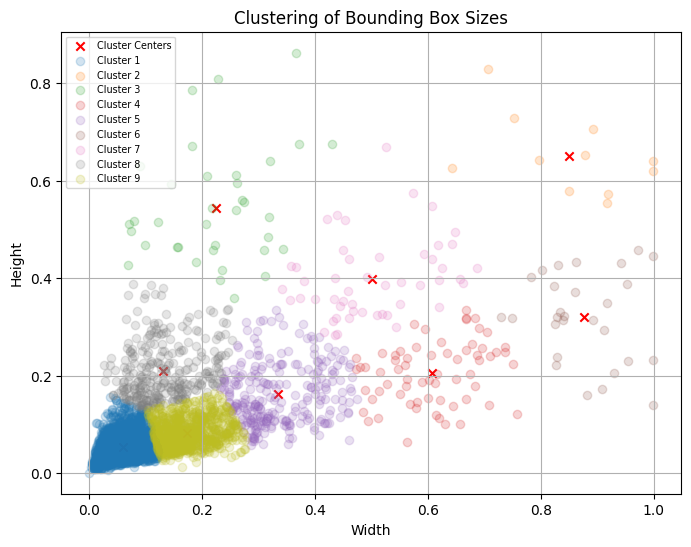

In [54]:
plt.figure(figsize=(8, 6))

plt.scatter(anchor_boxes[:, 0], anchor_boxes[:, 1], c='red', marker='x', label='Cluster Centers')

for i in range(k):
    cluster_points = bbox_sizes[cluster_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}', alpha=0.2)

plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Clustering of Bounding Box Sizes')

plt.legend(fontsize='x-small')

plt.grid(True)
plt.show()

In [55]:
def generate_anchor_boxes(anchor_points, scales, aspect_ratios):
    anchor_boxes = []
    for y, x in zip(anchor_points[0].flatten(), anchor_points[1].flatten()):
        for scale in scales:
            for ar in aspect_ratios:
                w = scale * np.sqrt(ar)
                h = scale / np.sqrt(ar)
                x_min = x - w / 2
                y_min = y - h / 2
                x_max = x + w / 2
                y_max = y + h / 2
                anchor_boxes.append([x_min, y_min, x_max, y_max])
    return np.array(anchor_boxes)

In [56]:
def plot_anchor_boxes(img, anchor_points, anchor_boxes, selected_points):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(img)

    ax.scatter(anchor_points[1].flatten(), anchor_points[0].flatten(), s=10, color='white')
    ax.axis('off')

    for idx in selected_points:
        for box in anchor_boxes[idx * len(scales) * len(aspect_ratios):(idx + 1) * len(scales) * len(aspect_ratios)]:
            rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                 linewidth=1, edgecolor='yellow', facecolor='none')
            ax.add_patch(rect)

    plt.show()

## Create Anchor Boxes around Anchor points

In [57]:
img_data = img_data_all[0]  # Use the first image for demonstration
img_height, img_width = img_data.size(1), img_data.size(2)

with torch.no_grad():
    out = backbone(img_data.unsqueeze(0))

out_c, out_h, out_w = out.size(1), out.size(2), out.size(3)
width_scale_factor = img_width // out_w
height_scale_factor = img_height // out_h

# Generate anchor points
xv, yv = generate_anchor_points(out_h, out_w, height_scale_factor, width_scale_factor)

# Define the scales and aspect ratios for the anchor boxes
scales = [16, 32, 64, 128]
aspect_ratios = [0.5, 1, 2]

anchor_boxes = generate_anchor_boxes((yv, xv), scales, aspect_ratios)

## plot all anchor boxes

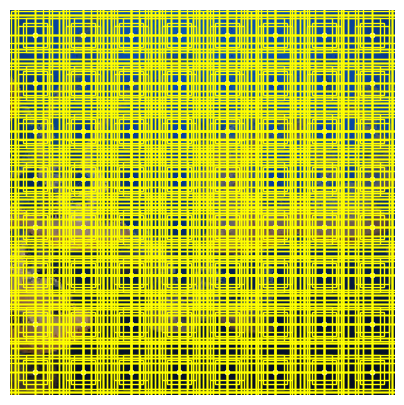

In [58]:
selected_points = [i for i in range(64)]
img = img_data.permute(1, 2, 0).cpu().numpy()
plot_anchor_boxes(img, (yv, xv), anchor_boxes, selected_points)

## plot anchor boxes on a single anchor point

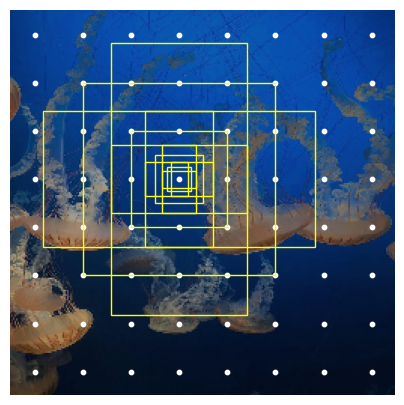

In [59]:
selected_points = [27]
img = img_data.permute(1, 2, 0).cpu().numpy()
plot_anchor_boxes(img, (yv, xv), anchor_boxes, selected_points)

In [60]:
def calc_giou(anchors, bbox):
    inter_x1 = torch.max(anchors[:, 0], bbox[0])
    inter_y1 = torch.max(anchors[:, 1], bbox[1])
    inter_x2 = torch.min(anchors[:, 2], bbox[2])
    inter_y2 = torch.min(anchors[:, 3], bbox[3])

    inter_area = (inter_x2 - inter_x1).clamp(min=0) * (inter_y2 - inter_y1).clamp(min=0)
    bbox_area = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
    anchors_area = (anchors[:, 2] - anchors[:, 0]) * (anchors[:, 3] - anchors[:, 1])

    union_area = anchors_area + bbox_area - inter_area
    iou = inter_area / union_area

    enclose_x1 = torch.min(anchors[:, 0], bbox[0])
    enclose_y1 = torch.min(anchors[:, 1], bbox[1])
    enclose_x2 = torch.max(anchors[:, 2], bbox[2])
    enclose_y2 = torch.max(anchors[:, 3], bbox[3])

    enclose_area = (enclose_x2 - enclose_x1) * (enclose_y2 - enclose_y1)
    giou = iou - (enclose_area - union_area) / enclose_area
    return giou

In [61]:
# Filters anchors to ensure they are within the image boundaries.
def filter_anchors(anchors, img_width, img_height):
    valid_mask = (
        (anchors[:, 0] >= 0) &
        (anchors[:, 1] >= 0) &
        (anchors[:, 2] <= img_width) &
        (anchors[:, 3] <= img_height)
    )
    filtered_anchors = anchors[valid_mask]
    return filtered_anchors

In [62]:
def generate_anchors(feature_map_size, scales, aspect_ratios, stride):
    feature_map_height, feature_map_width = feature_map_size
    anchors = []

    for y in range(feature_map_height):
        for x in range(feature_map_width):
            center_x = x * stride
            center_y = y * stride

            for scale in scales:
                for aspect_ratio in aspect_ratios:
                    w = scale * aspect_ratio
                    h = scale / aspect_ratio
                    anchors.append([
                        center_x - w / 2,
                        center_y - h / 2,
                        center_x + w / 2,
                        center_y + h / 2
                    ])

    anchors = torch.tensor(anchors, dtype=torch.float32)
    return anchors

In [63]:
def project_bboxes_to_feature_map(gt_bboxes, img_width, img_height, feature_map_width, feature_map_height):
    projected_bboxes = []
    scale_x = feature_map_width / img_width
    scale_y = feature_map_height / img_height
    for bbox in gt_bboxes:
        projected_bbox = bbox.clone()
        projected_bbox[:, [0, 2]] *= scale_x
        projected_bbox[:, [1, 3]] *= scale_y
        projected_bboxes.append(projected_bbox)
    return torch.stack(projected_bboxes)

In [64]:
def project_anchors_to_image_space(anchors, img_width, img_height):
    projected_anchors = anchors.clone()
    projected_anchors[:, [0, 2]] *= img_width
    projected_anchors[:, [1, 3]] *= img_height
    return projected_anchors

In [65]:
def find_positive_negative_anchors(anchors, projected_bboxes, pos_thresh, neg_thresh):
    pos_mask = torch.zeros(anchors.size(0), dtype=torch.bool)
    neg_mask = torch.zeros(anchors.size(0), dtype=torch.bool)
    for bbox in projected_bboxes:
        gious = calc_giou(anchors, bbox)
        pos_mask |= (gious >= pos_thresh)
        neg_mask |= (gious < neg_thresh)
    return pos_mask, neg_mask

## Building the model

In [66]:
def calc_cls_loss(pos_cls_logits, neg_cls_logits, batch_size):
    pos_labels = torch.ones(pos_cls_logits.size(0), dtype=torch.float32)
    neg_labels = torch.zeros(neg_cls_logits.size(0), dtype=torch.float32)
    labels = torch.cat([pos_labels, neg_labels])
    logits = torch.cat([pos_cls_logits, neg_cls_logits])
    return F.binary_cross_entropy_with_logits(logits, labels) / batch_size

def calc_bbox_reg_loss(gt_offsets, reg_offsets_pos, batch_size):
    return F.smooth_l1_loss(reg_offsets_pos, gt_offsets) / batch_size

In [67]:
def generate_proposals(anchors, offsets):
    # Change format of the anchor boxes from 'xyxy' to 'cxcywh'
    anchors = ops.box_convert(anchors, in_fmt='xyxy', out_fmt='cxcywh')

    proposals = torch.zeros_like(anchors)
    proposals[:, 0] = anchors[:, 0] + offsets[:, 0] * anchors[:, 2]
    proposals[:, 1] = anchors[:, 1] + offsets[:, 1] * anchors[:, 3]
    proposals[:, 2] = anchors[:, 2] * torch.exp(offsets[:, 2])
    proposals[:, 3] = anchors[:, 3] * torch.exp(offsets[:, 3])

    # Change format of proposals back from 'cxcywh' to 'xyxy'
    proposals = ops.box_convert(proposals, in_fmt='cxcywh', out_fmt='xyxy')

    return proposals

In [68]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        resnet = models.resnet101(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-3])

    def forward(self, img_data):
        return self.backbone(img_data)

class ProposalModule(nn.Module):
    def __init__(self, in_features, hidden_dim=512, n_anchors=9, p_dropout=0.3):
        super(ProposalModule, self).__init__()
        # Define the classification head
        self.cls_head = nn.Sequential(
            nn.Conv2d(in_features, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(p=p_dropout),
            nn.Conv2d(hidden_dim, n_anchors, kernel_size=1)
        )

        # Define the regression head
        self.reg_head = nn.Sequential(
            nn.Conv2d(in_features, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(p=p_dropout),
            nn.Conv2d(hidden_dim, n_anchors * 4, kernel_size=1)  # 4 for bounding box regression
        )

    def forward(self, feature_map, pos_anc_ind=None, neg_anc_ind=None, pos_anc_coords=None):
        cls_logits = self.cls_head(feature_map)
        reg_offsets = self.reg_head(feature_map)

        if self.training:
            # Training mode: compute confidence scores and offsets for positive anchors
            cls_logits_flat = cls_logits.permute(0, 2, 3, 1).reshape(-1)
            reg_offsets_flat = reg_offsets.permute(0, 2, 3, 1).reshape(-1, 4)
            pos_cls_logits = cls_logits_flat[pos_anc_ind]
            pos_reg_offsets = reg_offsets_flat[pos_anc_ind]

            # Generate proposals using the offsets
            proposals = generate_proposals(pos_anc_coords, pos_reg_offsets)

            return pos_cls_logits, pos_reg_offsets, proposals
        else:
            # Validation mode: just return the logits and offsets
            return cls_logits, reg_offsets

In [69]:
from torchvision.ops import RoIAlign

class ClassificationModule(nn.Module):
    def __init__(self, out_channels, n_classes, roi_size, hidden_dim=512, p_dropout=0.3):
        super(ClassificationModule, self).__init__()
        self.roi_align = RoIAlign(output_size=roi_size, spatial_scale=1.0, sampling_ratio=-1)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        roi_features = roi_size[0] * roi_size[1] * out_channels
        self.fc1 = nn.Linear(roi_features, hidden_dim)
        self.dropout = nn.Dropout(p=p_dropout)
        self.fc2 = nn.Linear(hidden_dim, n_classes)

    def forward(self, feature_map, proposals_list, gt_classes=None):
        # ROI Align pooling
        pooled_features = self.roi_align(feature_map, proposals_list)
        # Average pooling
        pooled_features = self.avg_pool(pooled_features)
        # Flatten the output
        flattened_features = pooled_features.view(pooled_features.size(0), -1)
        # Hidden fully connected network
        hidden_output = F.relu(self.fc1(flattened_features))
        hidden_output = self.dropout(hidden_output)
        # Classification scores
        cls_scores = self.fc2(hidden_output)

        if self.training:
            # Compute cross-entropy loss
            cls_loss = F.cross_entropy(cls_scores, gt_classes)
            return cls_scores, cls_loss
        else:
            return cls_scores

In [70]:
class RegressionModule(nn.Module):
    def __init__(self, out_channels, roi_size, hidden_dim=512, p_dropout=0.3):
        super(RegressionModule, self).__init__()
        self.roi_align = RoIAlign(output_size=roi_size, spatial_scale=1.0, sampling_ratio=-1)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        roi_features = roi_size[0] * roi_size[1] * out_channels
        self.fc1 = nn.Linear(roi_features, hidden_dim)
        self.dropout = nn.Dropout(p=p_dropout)
        self.fc2 = nn.Linear(hidden_dim, 4)  # 4 for bounding box regression

    def forward(self, feature_map, proposals_list):
        # ROI Align pooling
        pooled_features = self.roi_align(feature_map, proposals_list)
        # Average pooling
        pooled_features = self.avg_pool(pooled_features)
        # Flatten the output
        flattened_features = pooled_features.view(pooled_features.size(0), -1)
        # Hidden fully connected network
        hidden_output = F.relu(self.fc1(flattened_features))
        hidden_output = self.dropout(hidden_output)
        # Regression offsets
        reg_offsets = self.fc2(hidden_output)
        return reg_offsets

In [71]:
def calculate_rpn_loss(cls_logits, reg_offsets, pos_mask, neg_mask, gt_bboxes):
    # Classification loss
    cls_targets = torch.zeros_like(cls_logits)
    cls_targets[pos_mask, 1] = 1
    cls_targets[neg_mask, 0] = 1
    cls_loss = F.binary_cross_entropy_with_logits(cls_logits, cls_targets)

    # Regression loss
    pos_reg_offsets = reg_offsets[pos_mask]
    pos_gt_bboxes = gt_bboxes[pos_mask]
    reg_loss = F.smooth_l1_loss(pos_reg_offsets, pos_gt_bboxes)

    rpn_loss = cls_loss + reg_loss
    return rpn_loss

In [72]:
def filter_proposals(proposals, cls_logits, conf_thresh=0.5, nms_thresh=0.7):
    # Logits to probabilities
    probs = F.softmax(cls_logits, dim=-1)[:, 1]
    # Filter based on confidence threshold
    conf_mask = probs > conf_thresh
    proposals = proposals[conf_mask]
    probs = probs[conf_mask]
    # Apply NMS
    keep = nms(proposals, probs, nms_thresh)
    filtered_proposals = proposals[keep]
    return filtered_proposals

In [73]:
class RegionProposalNetwork(nn.Module):
    def __init__(self, img_size, out_size, out_channels):
        super(RegionProposalNetwork, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.proposal_module = ProposalModule(out_channels)
        self.img_size = img_size
        self.out_size = out_size
        self.scales = [16, 32, 64, 128]
        self.ratios = [0.5, 1, 2]
        self.pos_thresh = 0.7
        self.neg_thresh = 0.3

    def forward(self, images, gt_bboxes, gt_classes):
        batch_size = images.size(0)
        feature_map = self.feature_extractor(images)
        feature_map_size = (self.out_size[1], self.out_size[0])
        anchors = generate_anchors(feature_map_size, self.scales, self.ratios, stride=8)
        projected_bboxes = project_bboxes_to_feature_map(gt_bboxes, images.size(2), images.size(3), self.out_size[1], self.out_size[0])
        pos_mask, neg_mask = find_positive_negative_anchors(anchors, projected_bboxes, self.pos_thresh, self.neg_thresh)
        cls_logits, reg_offsets = self.proposal_module(feature_map)
        proposals = generate_proposals(anchors, reg_offsets)
        rpn_loss = calculate_rpn_loss(cls_logits, reg_offsets, pos_mask, neg_mask, projected_bboxes)
        return rpn_loss, proposals

    def inference(self, images, conf_thresh=0.5, nms_thresh=0.7):
        feature_map = self.feature_extractor(images)
        feature_map_size = (self.out_size[1], self.out_size[0])
        anchors = generate_anchors(feature_map_size, self.scales, self.ratios, stride=8)
        cls_logits, reg_offsets = self.proposal_module(feature_map)
        proposals = generate_proposals(anchors, reg_offsets)
        filtered_proposals = filter_proposals(proposals, cls_logits, conf_thresh, nms_thresh)
        return filtered_proposals

In [74]:
class TwoStageDetector(nn.Module):
    def __init__(self, img_size, out_channels, n_classes, roi_size):
        super(TwoStageDetector, self).__init__()
        self.rpn = RegionProposalNetwork(img_size, (32, 32), out_channels)
        self.classifier = ClassificationModule(out_channels, n_classes, roi_size)
        self.regressor = RegressionModule(out_channels, roi_size)

    def forward(self, images, gt_bboxes, gt_classes):
        batch_size = images.size(0)
        total_rpn_loss, proposals_list = self.rpn(images, gt_bboxes, gt_classes)
        all_proposals = torch.cat(proposals_list, dim=0)
        gt_classes_list = []

        for b in range(batch_size):
            gt_classes_list.extend(gt_classes[b])

        gt_classes_tensor = torch.tensor(gt_classes_list, dtype=torch.long).to(images.device)
        cls_scores, cls_loss = self.classifier(feature_map, all_proposals, gt_classes_tensor)
        reg_offsets = self.regressor(feature_map, all_proposals)

        total_loss = total_rpn_loss + cls_loss
        return total_loss, reg_offsets

    def inference(self, images, conf_thresh=0.5, nms_thresh=0.7):
        proposals_list = self.rpn.inference(images, conf_thresh, nms_thresh)
        batch_size = images.size(0)
        final_proposals = []

        for b in range(batch_size):
            proposals = proposals_list[b]
            class_logits = self.classifier(feature_map, proposals)
            class_probs = torch.softmax(class_logits, dim=-1)
            reg_offsets = self.regressor(feature_map, proposals)
            final_proposals.append((proposals, class_probs, reg_offsets))

        return final_proposals

# Train

In [75]:
img_width = 256
img_height = 256
name2idx = {'pad': -1,'fish':0, 'jellyfish':1, 'penguin':2, 'puffin':3, 'shark':4, 'starfish':5, 'stingray':6}
idx2name = {v:k for k, v in name2idx.items()}

img_size = (img_height, img_width)
out_size = (32, 32)
n_classes = len(name2idx) - 1
roi_size = (2, 2)

detector = TwoStageDetector(img_size, out_c, n_classes, roi_size)
detector = detector.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [76]:
def train(model, train_loader, optimizer, device):
    model.train()
    train_loss = 0.0
    for img_batch, target_batch in train_loader:
        img_batch = img_batch.to(torch.float32).to(device)
        gt_bboxes_batch = [t['boxes'].to(device) for t in target_batch]
        gt_classes_batch = [t['labels'].to(device) for t in target_batch]
        optimizer.zero_grad()
        loss = model(img_batch, gt_bboxes_batch, gt_classes_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader)

In [77]:
def validate(model, val_loader, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for img_batch, target_batch in val_loader:
            img_batch = img_batch.to(torch.float32).to(device)
            gt_bboxes_batch = [t['boxes'].to(device) for t in target_batch]
            gt_classes_batch = [t['labels'].to(device) for t in target_batch]
            loss = model(img_batch, gt_bboxes_batch, gt_classes_batch)
            val_loss += loss.item()
    return val_loss / len(val_loader)

In [78]:
def train_loop(model, configs):
    train_losses = []
    val_losses = []
    optimizer, scheduler = configs['optimizer'], configs['scheduler']
    best_loss = np.inf
    best_model = None

    for epoch in range(configs['epochs']):
        train_loss = train(model, configs['train_loader'], optimizer, configs['device'])
        val_loss = validate(model, configs['val_loader'], configs['device'])
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        scheduler.step()
        print(f"Epoch [{epoch+1}/{configs['epochs']}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Learning_rate: {optimizer.state_dict()['param_groups'][0]['lr']}")
        if val_loss < best_loss:
            print('saving the best model on validation data')
            best_loss = val_loss
            best_model = model
    history = {'train_loss': train_losses, 'val_loss': val_losses}
    return best_model, history

In [79]:
learning_rate = 1e-3
optimizer = optim.Adam(detector.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

configs = {
    'train_loader': train_loader,
    'val_loader': val_loader,
    'device': device,
    'optimizer': optimizer,
    'scheduler': scheduler,
    'epochs': 20
}

best_model, history = train_loop(detector, configs)

RuntimeError: The size of tensor a (12288) must match the size of tensor b (4) at non-singleton dimension 0